In [1]:
import numpy as np
import glob

from scipy import stats
import matplotlib.pyplot as plt

In [2]:
data_directory = "./vis_project_data/"

# Default weights adjusted to match results
cog_weights = np.array([0, -1, 1, 2, 2, 3, 5])
so_weights = np.array([-1, 0, 1, 2, 2, 3, 5])


# Types of sessions/files:
session_types = ["cog", "so"]
whatdoors = ["indoor", "outdoor"]
whichs = ["base", "inter"]
ca_peer_list = ["albert", "barry", "chris", "dana"]

# Combine to single itteratable list
combined_scenarios = [
    (ses_type, whatdoor, which)
    for ses_type in session_types
    for whatdoor in whatdoors
    for which in whichs
]

print(combined_scenarios)

[('cog', 'indoor', 'base'), ('cog', 'indoor', 'inter'), ('cog', 'outdoor', 'base'), ('cog', 'outdoor', 'inter'), ('so', 'indoor', 'base'), ('so', 'indoor', 'inter'), ('so', 'outdoor', 'base'), ('so', 'outdoor', 'inter')]


In [3]:
def combined_score(filename, weights):
    """Calculates the 'score' for a single session/file.
    Assumes total session duration is 360s, otherwise returns 'nan'.
    This could be modified simply to also return other details of the session."""
    with open(filename, "r") as file:
        score = 0.0
        total_duration = 0.0
        t_end_prev = 0.0
        for count, line in enumerate(file.readlines()):
            # print(count, line)
            data = line.split(",", 4)
            if count == 0:
                continue
            if line[0] == "*":
                break

            t_catagory = int(data[0])
            t_beg = int(data[1])
            t_end = int(data[2])

            if t_beg != t_end_prev:
                print("Error, missing time stamp?")
            t_end_prev = t_end

            assert t_end >= t_beg
            if count == 1:
                assert t_beg == 0

            duration = float(t_end - t_beg)
            total_duration += duration
            score += weights[t_catagory - 1] * duration
        return score / total_duration

In [4]:
def unique_pairs():
    """Returns list of unique ca/peer pairs"""
    all_files = glob.glob(data_directory + "/*.dtx")
    list = []
    for file in all_files:
        t = file.split("-")
        list.append([t[4], t[5]])

    return np.unique(list, axis=0)

unique_pairs()

array([['albert', 'lydia'],
       ['albert', 'ulrich'],
       ['barry', 'mario'],
       ['barry', 'viola'],
       ['chris', 'nellie'],
       ['chris', 'wendy'],
       ['dana', 'oscar'],
       ['dana', 'xavier'],
       ['ellie', 'peter'],
       ['ellie', 'yoshi'],
       ['ellie', 'zara']], dtype='<U6')

In [5]:
def get_files(ca, peer):
    files = []
    for ses_type, whatdoor, which in combined_scenarios:
        file_pattern = f"{ses_type}-*-{which}-*-{ca}-{peer}-{whatdoor}.dtx"
        files.extend(glob.glob(data_directory + file_pattern))
    return files

# get list of files for each pair 
def get_pair_files():
    ca_peer_list = unique_pairs()
    file_list = []
    for pair in ca_peer_list:
        files = get_files(pair[0], pair[1])
        file_list.append(files)
    return file_list

In [6]:
# get trained dyads
def get_trained_pair_files():
    ca_peer_list = unique_pairs()
    file_list = []
    for pair in ca_peer_list:
        files = get_files(pair[0], pair[1])
        if pair[1][0].upper() >= 'U' and pair[1][0].upper() <= 'Z':
            file_list.append(files)
    return file_list

In [7]:
# get untrained dyads
def get_untrained_pair_files():
    ca_peer_list = unique_pairs()
    file_list = []
    for pair in ca_peer_list:
        files = get_files(pair[0], pair[1])
        if pair[1][0].upper() >= 'L' and pair[1][0].upper() <= 'P':
            file_list.append(files)
    return file_list

In [8]:
# returns all the trials in a list for a given CA and scenario
def filter_ca_scenario(files, ses_type, which, ca, whatdoor):
    filtered_files = []
    for file_pair_list in files:
        for file in file_pair_list:
            file_name = file.split('\\')[-1]  # Extract the file name
            components = file_name.split('-')      
            #print("file components")
            #print(components)
            if len(components) >= 7 and \
                components[0] == ses_type and \
                components[-1].startswith(whatdoor) and \
                components[2] == which and \
                components[4] == ca:
                filtered_files.append(file)
    #print(filtered_files)
    return filtered_files

#filter_ca_scenario(get_trained_pair_files(), "cog", "base", "albert", "indoor")

def get_ca_scenario_stats(files, ses_type):
    if ses_type == "so":
        weights = so_weights
    else:
        weights = cog_weights
    scores = []
    statistics = []
    for file in files:
        temp_score = combined_score(file, weights)
        #print(temp_score)
        scores.append(temp_score)
    statistics.append(np.mean(scores))
    sdev = np.std(scores, ddof=1)  # "corrected" sdev
    statistics.append(sdev)
    statistics.append(sdev / np.sqrt(len(scores)))
    return statistics # returns mean, std, and standard error of mean

files = filter_ca_scenario(get_trained_pair_files(), "so", "base", "albert", "indoor")
get_ca_scenario_stats(files, "so")

[0.4961111111111111, 0.46407431423835827, 0.20754034264971352]

C:\Users\jyin1\AppData\Local\Temp\ipykernel_11056\1756658739.py:61: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x_before, y_before, yerr=errors_before, fmt='o', label='Before', color='black', marker='s')
C:\Users\jyin1\AppData\Local\Temp\ipykernel_11056\1756658739.py:62: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x_after, y_after, yerr=errors_after, fmt='o', label='After', color='black', marker='^')
C:\Users\jyin1\AppData\Local\Temp\ipykernel_11056\1756658739.py:65: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(5, before_avg[-1], yerr=before_err[-1], fmt='o', color='blue', marker='s')
C:\Users\jyin1\AppD

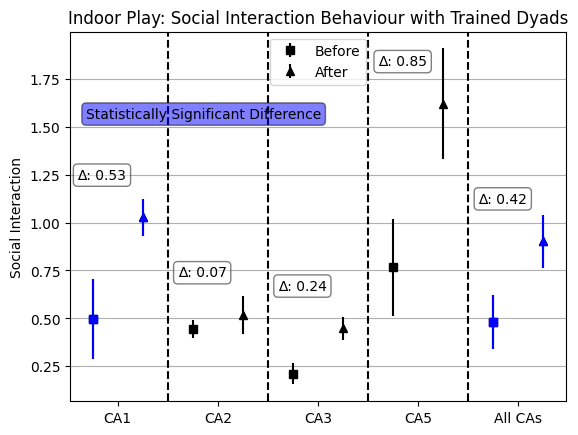

In [9]:
# get data points for graph: trained dyads indoor play social 

# before training
before_avg = []
before_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "base", ca, "indoor"), "so")
    before_avg.append(statistics[0])
    before_err.append(statistics[2])

overall_bef_avg = np.mean(before_avg)
overall_bef_err = np.mean(before_err)
before_avg.append(overall_bef_avg)
before_err.append(overall_bef_err)

# after training
after_avg = []
after_err = []
for ca in ca_peer_list:
    statistics = get_ca_scenario_stats(
        filter_ca_scenario(
            get_trained_pair_files(), "so", "inter", ca, "indoor"), "so")
    after_avg.append(statistics[0])
    after_err.append(statistics[2])
    
overall_af_avg = np.mean(after_avg)
overall_af_err = np.mean(after_err)
after_avg.append(overall_af_avg)
after_err.append(overall_af_err)
#print(after_avg)
#print(after_err)

differences = []
for i in range(len(before_avg)):
    differences.append(after_avg[i] - before_avg[i])
    
# Print results
#print("Paired t-test results:")
#print("t-statistic:", t_statistic)
#print("p-value:", p_value)

# Interpret the p-value
#if p_value <= 0.05:
   # print("The change is statistically significant at the α=0.05 level.")
#else:
    #print("The change is not statistically significant at the α=0.05 level.")

# Data for "before" and "after" measurements
x_before = np.array([1, 2, 3, 4, 5])
y_before = before_avg
errors_before = before_err

x_after = np.array([1.5, 2.5, 3.5, 4.5, 5.5])
y_after = after_avg
errors_after = after_err

# Plotting the error bar graph
plt.errorbar(x_before, y_before, yerr=errors_before, fmt='o', label='Before', color='black', marker='s')
plt.errorbar(x_after, y_after, yerr=errors_after, fmt='o', label='After', color='black', marker='^')

# Change color for "All CAs" data point
plt.errorbar(5, before_avg[-1], yerr=before_err[-1], fmt='o', color='blue', marker='s')
plt.errorbar(5.5, after_avg[-1], yerr=after_err[-1], fmt='o', color='blue', marker='^')

# Change color for "All CAs" data point
plt.errorbar(1, before_avg[0], yerr=before_err[0], fmt='o', color='blue', marker='s')
plt.errorbar(1.5, after_avg[0], yerr=after_err[0], fmt='o', color='blue', marker='^')

# Adding vertical lines to separate groups
for i in range(len(x_before) - 1):
    plt.axvline(x_before[i] + 0.75, color='black', linestyle='--')
    
# Adding labels and title
plt.ylabel('Social Interaction')
plt.title('Indoor Play: Social Interaction Behaviour with Trained Dyads')

x_midpoints = (x_before + x_after) / 2

# Customizing x-axis ticks and labels
plt.xticks(x_midpoints, ['CA1', 'CA2', 'CA3', 'CA5', "All CAs"])

# Annotate each xtick with a box displaying the differences
for i, (x, diff) in enumerate(zip(x_midpoints, differences)):
    plt.text(x - 0.4, max(y_before[i], y_after[i]) + 0.2, f'∆: {diff:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))
    
# Adding legend
plt.legend()
plt.text(0.15, 0.7, "Statistically Significant Difference", bbox=dict(facecolor='blue', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'), transform=plt.gcf().transFigure)

# Display the plot
plt.grid(axis='y')
plt.show()


In [10]:
from scipy import stats
trained_files = get_trained_pair_files()
# Loop through each CA
before_data = []  # Data before training for current CA
after_data = []   # Data after training for current CA
for i, ca in enumerate(ca_peer_list):
    # Get data for the current CA
    # Extract data for the current CA
    before_files = filter_ca_scenario(trained_files, "so", "base", ca, "indoor")
    for file in before_files:
        score = combined_score(file, so_weights)
        before_data.append(score)
    after_files = filter_ca_scenario(trained_files, "so", "inter", ca, "indoor")
    for file in after_files:
        score = combined_score(file, so_weights)
        after_data.append(score)

# Perform paired t-test for the current CA
t_statistic, p_value = stats.ttest_ind(before_data, after_data)
print("Independent two-sample t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)



Independent two-sample t-test results:
t-statistic: -2.083315746643066
p-value: 0.04122186391308713


In [11]:
from scipy import stats
trained_files = get_trained_pair_files()
# Loop through each CA
avg_before = []
avg_after = []
for i, ca in enumerate(ca_peer_list):
    # Get data for the current CA
    before_data = []  # Data before training for current CA
    after_data = []   # Data after training for current CA
        
    # Extract data for the current CA
    before_files = filter_ca_scenario(trained_files, "so", "base", ca, "indoor")
    for file in before_files:
        score = combined_score(file, so_weights)
        before_data.append(score)
    after_files = filter_ca_scenario(trained_files, "so", "inter", ca, "indoor")
    for file in after_files:
        score = combined_score(file, so_weights)
        after_data.append(score)

    # Perform paired t-test for the current CA
    t_statistic, p_value = stats.ttest_ind(before_data, after_data)
    print("Independent two-sample t-test results:")
    print("t-statistic:", t_statistic)
    print("p-value:", p_value)
    if p_value <= 0.05:
        print(ca)


Independent two-sample t-test results:
t-statistic: -2.6492686948336175
p-value: 0.020039612741507562
albert
Independent two-sample t-test results:
t-statistic: -0.4007371538388608
p-value: 0.6946625337230197
Independent two-sample t-test results:
t-statistic: -2.140509783102916
p-value: 0.05039950451236848
Independent two-sample t-test results:
t-statistic: -1.9973987943433025
p-value: 0.06204463848761089
